In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from keras import backend as K
import matplotlib.pyplot as plt
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df = pd.get_dummies(df,columns=["CHAS"]) #to categorical


C:\Users\Javier\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Javier\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<a id="segundo"></a>
## 2. Deep Networks
Las *deep network*, o lo que hoy en día se conoce como *deep learning*, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).  
Este tipo de redes neuronales tienen una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes *feed forward*, siendo bastante dificiles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?  

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" title="Title text" width="80%" height="20%" />



En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el *backpropagation* hacia las primeras capas de la red. 

> a) Se trabajará con las etiquetas escaladas uniformemente, es decir, $\mu=0$ y $\sigma=1$, ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de pruebas.

```python
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = X_train_scaled.pop('MEDV').values.reshape(-1,1)
```

In [2]:
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)

In [3]:
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train = df_train.pop('MEDV').reshape(-1,1)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
y_test = df_test.pop('MEDV').reshape(-1,1)

C:\Users\Javier\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Javier\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


In [4]:
np.asmatrix(X_train_scaled).shape
y_train.shape

(379, 1)

> b) Para el mismo problema definido anteriormente ([sección 1](#primero)) se entrenará diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (*loss*) para el conjunto de entrenamiento respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de *gradients* (__[link](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gradients)__) en el *backend* de Keras. Deberá generar un **histograma** para todos los pesos de cada capa antes y despues del entrenamiento con 300 *epochs*. Comente.


In [5]:
def getGradients(modelo, xTrain, yTrain):
    loss = keras.losses.mean_squared_error(modelo.output, yTrain)
    listOfVariableTensors = modelo.trainable_weights
    gradients = K.gradients(loss, listOfVariableTensors)
    sess = K.get_session()
    evaluated_gradients = sess.run(gradients, feed_dict={model.input:xTrain.as_matrix()})
    return [gradient/len(yTrain) for gradient in evaluated_gradients]

In [6]:
def getDataFromGrad(layers, gradsBefore, gradsAfter):
    
    nLayers = len(layers)
    nIter = 0
    nLayer = 0
    result = []
    
    for i in range(2*nLayers):
        auxList = []
        result.append(auxList)
        
    for gradients in [gradsBefore, gradsAfter]:
        nLayer = 0
        for layer in gradients:
            if (nLayer//2)+1 in layers:
                if nIter%2 == 0:
                    for vector in layer:
                        for element in vector:
                            result[(nIter//2)].append(element)
                else:
                    for element in layer:
                        result[(nIter//2)].append(element)
                nIter += 1
            nLayer+=1
    
    return result

In [7]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
grad_bef_B = getGradients(model, X_train_scaled, y_train)

In [9]:
model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=1, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s 371us/step - loss: 107.5202 - val_loss: 47.0990
Epoch 2/300
379/379 [==============================] - 0s 124us/step - loss: 31.2659 - val_loss: 33.1570
Epoch 3/300
379/379 [==============================] - 0s 82us/step - loss: 24.0725 - val_loss: 27.5746
Epoch 4/300
379/379 [==============================] - 0s 137us/step - loss: 18.5577 - val_loss: 22.9995
Epoch 5/300
379/379 [==============================] - 0s 82us/step - loss: 15.1198 - val_loss: 19.8343
Epoch 6/300
379/379 [==============================] - 0s 124us/step - loss: 12.3297 - val_loss: 17.4925
Epoch 7/300
379/379 [==============================] - 0s 141us/step - loss: 11.2696 - val_loss: 15.5335
Epoch 8/300
379/379 [==============================] - 0s 100us/step - loss: 10.2328 - val_loss: 14.5059
Epoch 9/300
379/379 [==============================] - 0s 45us/step - loss: 9.6510 - val_loss: 13.1021
Epoch 10/300

379/379 [==============================] - 0s 124us/step - loss: 0.2409 - val_loss: 0.2390
Epoch 80/300
379/379 [==============================] - 0s 144us/step - loss: 0.2337 - val_loss: 0.2418
Epoch 81/300
379/379 [==============================] - 0s 60us/step - loss: 0.2215 - val_loss: 0.2284
Epoch 82/300
379/379 [==============================] - 0s 99us/step - loss: 0.2245 - val_loss: 0.2126
Epoch 83/300
379/379 [==============================] - 0s 90us/step - loss: 0.2227 - val_loss: 0.2066
Epoch 84/300
379/379 [==============================] - 0s 206us/step - loss: 0.2301 - val_loss: 0.2340
Epoch 85/300
379/379 [==============================] - 0s 124us/step - loss: 0.2130 - val_loss: 0.2104
Epoch 86/300
379/379 [==============================] - 0s 93us/step - loss: 0.2135 - val_loss: 0.2218
Epoch 87/300
379/379 [==============================] - 0s 115us/step - loss: 0.2042 - val_loss: 0.2393
Epoch 88/300
379/379 [==============================] - 0s 82us/step - loss: 0.21

Epoch 158/300
379/379 [==============================] - 0s 124us/step - loss: 0.1435 - val_loss: 0.1352
Epoch 159/300
379/379 [==============================] - 0s 132us/step - loss: 0.1447 - val_loss: 0.1358
Epoch 160/300
379/379 [==============================] - 0s 124us/step - loss: 0.1457 - val_loss: 0.1506
Epoch 161/300
379/379 [==============================] - 0s 206us/step - loss: 0.1444 - val_loss: 0.1357
Epoch 162/300
379/379 [==============================] - 0s 82us/step - loss: 0.1396 - val_loss: 0.1357
Epoch 163/300
379/379 [==============================] - 0s 124us/step - loss: 0.1471 - val_loss: 0.1399
Epoch 164/300
379/379 [==============================] - 0s 82us/step - loss: 0.1392 - val_loss: 0.1369
Epoch 165/300
379/379 [==============================] - 0s 179us/step - loss: 0.1458 - val_loss: 0.1407
Epoch 166/300
379/379 [==============================] - 0s 122us/step - loss: 0.1365 - val_loss: 0.1307
Epoch 167/300
379/379 [==============================] - 

379/379 [==============================] - 0s 125us/step - loss: 0.1097 - val_loss: 0.1098
Epoch 237/300
379/379 [==============================] - 0s 94us/step - loss: 0.1098 - val_loss: 0.1165
Epoch 238/300
379/379 [==============================] - 0s 124us/step - loss: 0.1087 - val_loss: 0.1203
Epoch 239/300
379/379 [==============================] - 0s 165us/step - loss: 0.1074 - val_loss: 0.1151
Epoch 240/300
379/379 [==============================] - 0s 82us/step - loss: 0.1043 - val_loss: 0.1303
Epoch 241/300
379/379 [==============================] - 0s 106us/step - loss: 0.1102 - val_loss: 0.1086
Epoch 242/300
379/379 [==============================] - 0s 223us/step - loss: 0.1080 - val_loss: 0.1082
Epoch 243/300
379/379 [==============================] - 0s 82us/step - loss: 0.1121 - val_loss: 0.1076
Epoch 244/300
379/379 [==============================] - 0s 104us/step - loss: 0.1050 - val_loss: 0.1174
Epoch 245/300
379/379 [==============================] - 0s 154us/step -

In [10]:
grad_aft_B = getGradients(model, X_train_scaled, y_train)

In [11]:
itemB_data = getDataFromGrad([1,2], grad_bef_B, grad_aft_B)

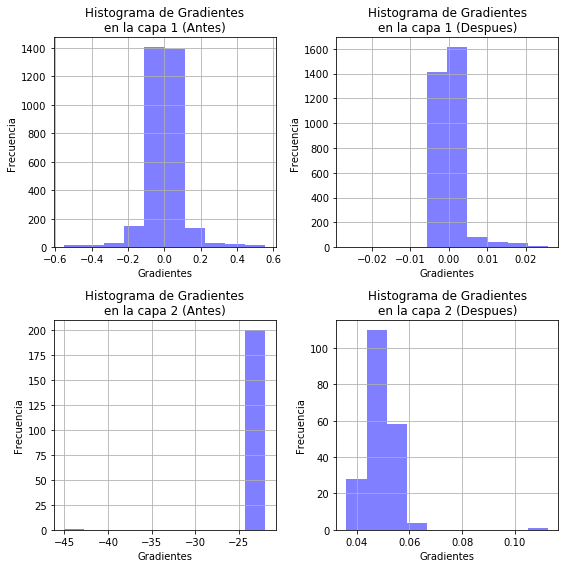

In [12]:
f, axarr = plt.subplots(2, 2,figsize=(8,8))

index = 0
realIndex = 0
for index in range(len(itemB_data)):
    
    if index%2 == 0:
        realIndex = int(index/2)
    else:
        realIndex = int(len(itemB_data)/2 + index//2)
        
    f.axes[index].hist(itemB_data[realIndex], facecolor='blue', alpha=0.5)
    f.axes[index].set_xlabel('Gradientes')
    f.axes[index].set_ylabel('Frecuencia')
    number = (index//2)+1
    if index%2 == 0:
        tiempo = "Antes"
    else:
        tiempo = "Despues"
    f.axes[index].set_title('Histograma de Gradientes\nen la capa '+str(number)+' ('+tiempo+')')
    f.axes[index].grid(True)
    index+=1
    
plt.tight_layout()
plt.show()

> c) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho mas profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visual visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar.

In [13]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200,  kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [14]:
grad_bef_C = getGradients(model, X_train_scaled, y_train)

In [15]:
model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=1, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s 533us/step - loss: 144.3966 - val_loss: 87.9465
Epoch 2/300
379/379 [==============================] - 0s 206us/step - loss: 89.3321 - val_loss: 102.1075
Epoch 3/300
379/379 [==============================] - 0s 124us/step - loss: 96.3609 - val_loss: 82.5150
Epoch 4/300
379/379 [==============================] - 0s 124us/step - loss: 96.9875 - val_loss: 87.7398
Epoch 5/300
379/379 [==============================] - 0s 247us/step - loss: 87.4614 - val_loss: 86.3553
Epoch 6/300
379/379 [==============================] - 0s 165us/step - loss: 89.5069 - val_loss: 82.2068
Epoch 7/300
379/379 [==============================] - 0s 227us/step - loss: 87.1995 - val_loss: 83.8439
Epoch 8/300
379/379 [==============================] - 0s 124us/step - loss: 90.4150 - val_loss: 98.7803
Epoch 9/300
379/379 [==============================] - 0s 165us/step - loss: 87.8802 - val_loss: 84.0866
Epoch 1

379/379 [==============================] - 0s 124us/step - loss: 84.4520 - val_loss: 82.4721
Epoch 79/300
379/379 [==============================] - 0s 206us/step - loss: 87.0236 - val_loss: 80.6827
Epoch 80/300
379/379 [==============================] - 0s 124us/step - loss: 85.3710 - val_loss: 79.8834
Epoch 81/300
379/379 [==============================] - 0s 82us/step - loss: 85.5395 - val_loss: 80.4217
Epoch 82/300
379/379 [==============================] - 0s 168us/step - loss: 85.2392 - val_loss: 78.4878
Epoch 83/300
379/379 [==============================] - 0s 124us/step - loss: 82.9250 - val_loss: 80.3811
Epoch 84/300
379/379 [==============================] - 0s 206us/step - loss: 79.2178 - val_loss: 74.1959
Epoch 85/300
379/379 [==============================] - 0s 142us/step - loss: 74.0457 - val_loss: 68.8777
Epoch 86/300
379/379 [==============================] - 0s 103us/step - loss: 66.4482 - val_loss: 71.2605
Epoch 87/300
379/379 [==============================] - 0s 8

Epoch 156/300
379/379 [==============================] - 0s 176us/step - loss: 0.7306 - val_loss: 1.0028
Epoch 157/300
379/379 [==============================] - 0s 165us/step - loss: 2.2787 - val_loss: 2.3961
Epoch 158/300
379/379 [==============================] - 0s 124us/step - loss: 0.9263 - val_loss: 0.7876
Epoch 159/300
379/379 [==============================] - 0s 82us/step - loss: 0.6064 - val_loss: 0.7469
Epoch 160/300
379/379 [==============================] - 0s 167us/step - loss: 0.6375 - val_loss: 0.8906
Epoch 161/300
379/379 [==============================] - 0s 172us/step - loss: 0.5493 - val_loss: 0.9250
Epoch 162/300
379/379 [==============================] - 0s 124us/step - loss: 0.5803 - val_loss: 0.6259
Epoch 163/300
379/379 [==============================] - 0s 155us/step - loss: 1.4189 - val_loss: 0.9110
Epoch 164/300
379/379 [==============================] - 0s 102us/step - loss: 1.3379 - val_loss: 1.5229
Epoch 165/300
379/379 [==============================] -

379/379 [==============================] - 0s 124us/step - loss: 0.4763 - val_loss: 0.4309
Epoch 235/300
379/379 [==============================] - 0s 224us/step - loss: 0.3729 - val_loss: 0.4664
Epoch 236/300
379/379 [==============================] - 0s 148us/step - loss: 1.1624 - val_loss: 1.6555
Epoch 237/300
379/379 [==============================] - 0s 82us/step - loss: 2.3273 - val_loss: 2.9041
Epoch 238/300
379/379 [==============================] - 0s 124us/step - loss: 1.7901 - val_loss: 1.3979
Epoch 239/300
379/379 [==============================] - 0s 210us/step - loss: 0.9113 - val_loss: 1.1769
Epoch 240/300
379/379 [==============================] - 0s 165us/step - loss: 0.7553 - val_loss: 0.2885
Epoch 241/300
379/379 [==============================] - 0s 124us/step - loss: 0.3836 - val_loss: 0.3980
Epoch 242/300
379/379 [==============================] - 0s 124us/step - loss: 0.2010 - val_loss: 0.1662
Epoch 243/300
379/379 [==============================] - 0s 124us/step

In [16]:
grad_aft_C = getGradients(model, X_train_scaled, y_train)

In [17]:
itemC_data = getDataFromGrad([1,2,3,4], grad_bef_C, grad_aft_C)

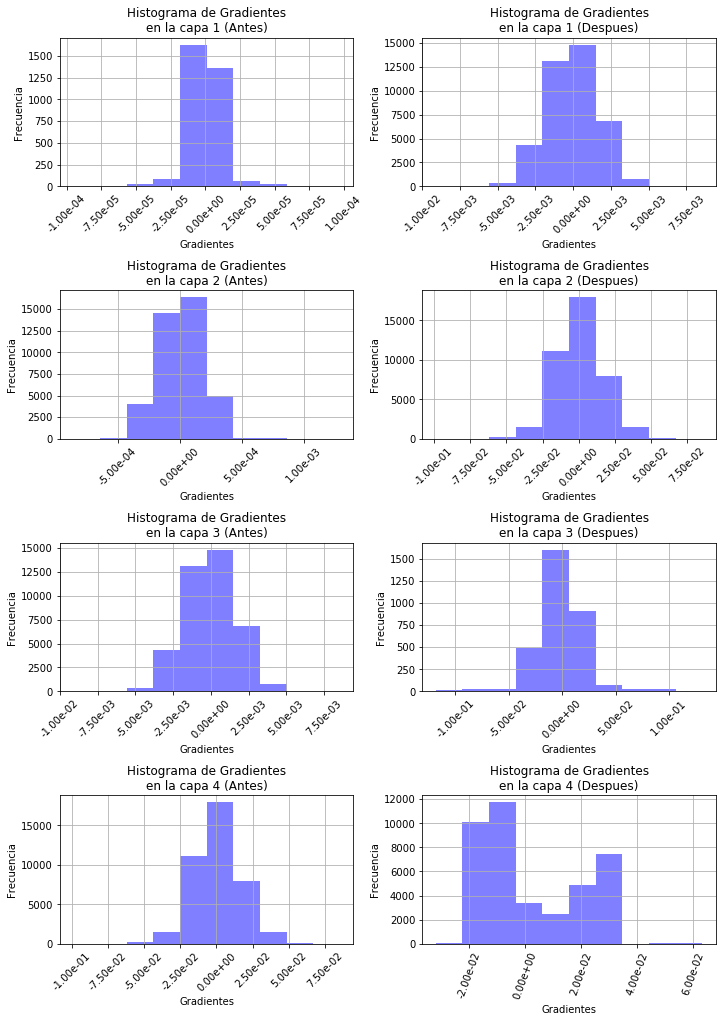

In [18]:
f, ax = plt.subplots(4,2,figsize=(10,14))
ax = ax.T.flatten()
for i in range(len(ax)):
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45)

index = 0
realIndex = 0
for index in range(len(itemC_data)):
    
    if index%2 == 0:
        realIndex = int(index/2)
    else:
        realIndex = int(len(itemB_data)/2 + index//2)
        
    f.axes[index].hist(itemC_data[realIndex], facecolor='blue', alpha=0.5)
    f.axes[index].set_xlabel('Gradientes')
    f.axes[index].set_ylabel('Frecuencia')
    number = (index//2)+1
    if index%2 == 0:
        tiempo = "Antes"
    else:
        tiempo = "Despues"
    f.axes[index].set_title('Histograma de Gradientes\nen la capa '+str(number)+' ('+tiempo+')')
    f.axes[index].grid(True)
    f.axes[index].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
    index+=1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 
plt.xticks(rotation=70)
plt.show()

> d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[1]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar.


In [19]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(200, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [20]:
grad_bef_D = getGradients(model, X_train_scaled, y_train)

In [21]:
model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=1, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s 567us/step - loss: 146.0101 - val_loss: 84.4598
Epoch 2/300
379/379 [==============================] - 0s 124us/step - loss: 88.0624 - val_loss: 87.4237
Epoch 3/300
379/379 [==============================] - 0s 206us/step - loss: 93.9515 - val_loss: 81.7203
Epoch 4/300
379/379 [==============================] - 0s 165us/step - loss: 89.8374 - val_loss: 82.0899
Epoch 5/300
379/379 [==============================] - 0s 165us/step - loss: 91.9389 - val_loss: 84.8971
Epoch 6/300
379/379 [==============================] - 0s 109us/step - loss: 94.6208 - val_loss: 83.2242
Epoch 7/300
379/379 [==============================] - 0s 206us/step - loss: 91.3707 - val_loss: 82.2699
Epoch 8/300
379/379 [==============================] - 0s 124us/step - loss: 92.3801 - val_loss: 88.5938
Epoch 9/300
379/379 [==============================] - 0s 165us/step - loss: 90.5733 - val_loss: 81.7774
Epoch 10

379/379 [==============================] - 0s 124us/step - loss: 1.7475 - val_loss: 2.2980
Epoch 79/300
379/379 [==============================] - 0s 206us/step - loss: 1.8227 - val_loss: 2.1496
Epoch 80/300
379/379 [==============================] - 0s 165us/step - loss: 1.8713 - val_loss: 4.2732
Epoch 81/300
379/379 [==============================] - 0s 142us/step - loss: 2.1152 - val_loss: 5.6148
Epoch 82/300
379/379 [==============================] - 0s 145us/step - loss: 9.7664 - val_loss: 5.9264
Epoch 83/300
379/379 [==============================] - 0s 180us/step - loss: 5.4130 - val_loss: 3.5355
Epoch 84/300
379/379 [==============================] - 0s 206us/step - loss: 1.5771 - val_loss: 2.2291
Epoch 85/300
379/379 [==============================] - 0s 151us/step - loss: 1.8990 - val_loss: 4.1295
Epoch 86/300
379/379 [==============================] - 0s 124us/step - loss: 3.2407 - val_loss: 1.6614
Epoch 87/300
379/379 [==============================] - 0s 124us/step - loss:

379/379 [==============================] - 0s 133us/step - loss: 0.2966 - val_loss: 0.3027
Epoch 157/300
379/379 [==============================] - 0s 74us/step - loss: 0.4350 - val_loss: 0.2697
Epoch 158/300
379/379 [==============================] - 0s 165us/step - loss: 0.3308 - val_loss: 0.2651
Epoch 159/300
379/379 [==============================] - 0s 165us/step - loss: 0.3316 - val_loss: 0.2281
Epoch 160/300
379/379 [==============================] - 0s 165us/step - loss: 0.2242 - val_loss: 0.2390
Epoch 161/300
379/379 [==============================] - 0s 112us/step - loss: 0.2322 - val_loss: 0.1684
Epoch 162/300
379/379 [==============================] - 0s 124us/step - loss: 0.4480 - val_loss: 1.1191
Epoch 163/300
379/379 [==============================] - 0s 82us/step - loss: 1.2430 - val_loss: 1.6563
Epoch 164/300
379/379 [==============================] - 0s 247us/step - loss: 2.5345 - val_loss: 2.3483
Epoch 165/300
379/379 [==============================] - 0s 162us/step 

379/379 [==============================] - 0s 124us/step - loss: 0.1631 - val_loss: 0.1732
Epoch 235/300
379/379 [==============================] - 0s 124us/step - loss: 0.1534 - val_loss: 0.0710
Epoch 236/300
379/379 [==============================] - 0s 124us/step - loss: 0.1262 - val_loss: 0.1946
Epoch 237/300
379/379 [==============================] - 0s 267us/step - loss: 0.1175 - val_loss: 0.0724
Epoch 238/300
379/379 [==============================] - 0s 186us/step - loss: 0.0789 - val_loss: 0.0868
Epoch 239/300
379/379 [==============================] - 0s 124us/step - loss: 0.0710 - val_loss: 0.0639
Epoch 240/300
379/379 [==============================] - 0s 199us/step - loss: 0.1804 - val_loss: 0.2255
Epoch 241/300
379/379 [==============================] - 0s 102us/step - loss: 0.1380 - val_loss: 0.1124
Epoch 242/300
379/379 [==============================] - 0s 124us/step - loss: 0.0794 - val_loss: 0.0664
Epoch 243/300
379/379 [==============================] - 0s 110us/ste

In [22]:
grad_aft_D = getGradients(model, X_train_scaled, y_train)

In [23]:
itemD_data = getDataFromGrad([1,2,3,4], grad_bef_D, grad_aft_D)

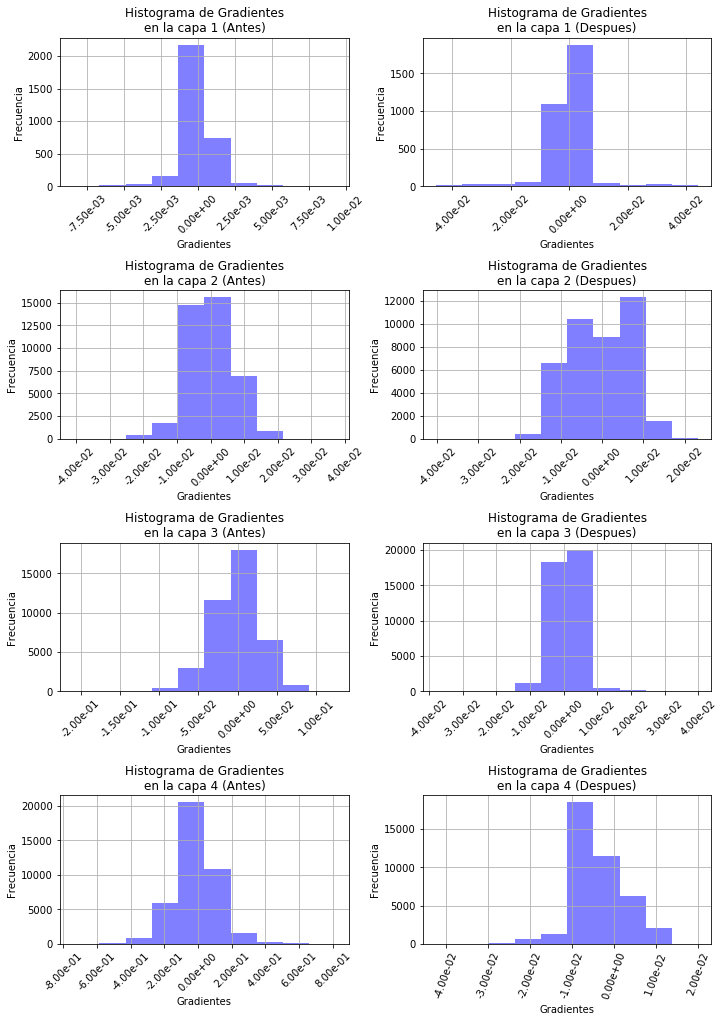

In [24]:
f, ax = plt.subplots(4,2,figsize=(10,14))
ax = ax.T.flatten()
for i in range(len(ax)):
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45)

index = 0
realIndex = 0
for index in range(len(itemD_data)):
    
    if index%2 == 0:
        realIndex = int(index/2)
    else:
        realIndex = int(len(itemD_data)/2 + index//2)
        
    f.axes[index].hist(itemD_data[realIndex], facecolor='blue', alpha=0.5)
    f.axes[index].set_xlabel('Gradientes')
    f.axes[index].set_ylabel('Frecuencia')
    number = (index//2)+1
    if index%2 == 0:
        tiempo = "Antes"
    else:
        tiempo = "Despues"
    f.axes[index].set_title('Histograma de Gradientes\nen la capa '+str(number)+' ('+tiempo+')')
    f.axes[index].grid(True)
    f.axes[index].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
    index+=1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 
plt.xticks(rotation=70)
plt.show()

> e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform* y comparar con la inicialización de He [[2]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.

In [25]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
model.add(Dense(200,  kernel_initializer='uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [26]:
grad_bef_E1 = getGradients(model, X_train_scaled, y_train)

In [27]:
model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=1, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s 660us/step - loss: 407.6352 - val_loss: 413.9972
Epoch 2/300
379/379 [==============================] - 0s 137us/step - loss: 172.7341 - val_loss: 82.6944
Epoch 3/300
379/379 [==============================] - 0s 148us/step - loss: 81.4997 - val_loss: 57.2567
Epoch 4/300
379/379 [==============================] - 0s 165us/step - loss: 74.9478 - val_loss: 119.0690
Epoch 5/300
379/379 [==============================] - 0s 247us/step - loss: 81.5169 - val_loss: 74.7363
Epoch 6/300
379/379 [==============================] - 0s 164us/step - loss: 96.7167 - val_loss: 85.5299
Epoch 7/300
379/379 [==============================] - 0s 84us/step - loss: 85.9442 - val_loss: 82.7279
Epoch 8/300
379/379 [==============================] - 0s 206us/step - loss: 85.7922 - val_loss: 81.7704
Epoch 9/300
379/379 [==============================] - 0s 165us/step - loss: 86.3355 - val_loss: 85.4494
Epoch 

Epoch 78/300
379/379 [==============================] - 0s 100us/step - loss: 128.3153 - val_loss: 81.7011
Epoch 79/300
379/379 [==============================] - 0s 123us/step - loss: 84.8262 - val_loss: 81.8029
Epoch 80/300
379/379 [==============================] - 0s 206us/step - loss: 91.9985 - val_loss: 90.0769
Epoch 81/300
379/379 [==============================] - 0s 124us/step - loss: 121.2242 - val_loss: 81.6995
Epoch 82/300
379/379 [==============================] - 0s 137us/step - loss: 86.5013 - val_loss: 82.2895
Epoch 83/300
379/379 [==============================] - 0s 124us/step - loss: 89.4256 - val_loss: 83.4562
Epoch 84/300
379/379 [==============================] - 0s 165us/step - loss: 86.5823 - val_loss: 84.2973
Epoch 85/300
379/379 [==============================] - 0s 124us/step - loss: 88.4707 - val_loss: 82.2446
Epoch 86/300
379/379 [==============================] - 0s 163us/step - loss: 85.4508 - val_loss: 81.7355
Epoch 87/300
379/379 [======================

Epoch 155/300
379/379 [==============================] - 0s 179us/step - loss: 87.0753 - val_loss: 83.1937
Epoch 156/300
379/379 [==============================] - 0s 93us/step - loss: 86.9048 - val_loss: 82.4989
Epoch 157/300
379/379 [==============================] - 0s 124us/step - loss: 85.9775 - val_loss: 81.8124
Epoch 158/300
379/379 [==============================] - 0s 206us/step - loss: 85.7569 - val_loss: 83.1690
Epoch 159/300
379/379 [==============================] - 0s 124us/step - loss: 87.7270 - val_loss: 86.1693
Epoch 160/300
379/379 [==============================] - 0s 142us/step - loss: 87.4109 - val_loss: 84.0579
Epoch 161/300
379/379 [==============================] - 0s 124us/step - loss: 87.9902 - val_loss: 82.1218
Epoch 162/300
379/379 [==============================] - 0s 247us/step - loss: 85.4300 - val_loss: 82.3918
Epoch 163/300
379/379 [==============================] - 0s 174us/step - loss: 87.9015 - val_loss: 82.4304
Epoch 164/300
379/379 [===============

379/379 [==============================] - 0s 206us/step - loss: 87.1533 - val_loss: 83.3863
Epoch 232/300
379/379 [==============================] - 0s 124us/step - loss: 85.7477 - val_loss: 82.5742
Epoch 233/300
379/379 [==============================] - 0s 124us/step - loss: 87.0132 - val_loss: 81.7152
Epoch 234/300
379/379 [==============================] - 0s 82us/step - loss: 86.7582 - val_loss: 82.5548
Epoch 235/300
379/379 [==============================] - 0s 124us/step - loss: 85.6620 - val_loss: 83.2255
Epoch 236/300
379/379 [==============================] - 0s 289us/step - loss: 87.7266 - val_loss: 82.2563
Epoch 237/300
379/379 [==============================] - 0s 198us/step - loss: 87.1232 - val_loss: 83.0713
Epoch 238/300
379/379 [==============================] - 0s 165us/step - loss: 86.6142 - val_loss: 83.2300
Epoch 239/300
379/379 [==============================] - 0s 165us/step - loss: 87.3546 - val_loss: 81.9273
Epoch 240/300
379/379 [=============================

In [28]:
grad_aft_E1 = getGradients(model, X_train_scaled, y_train)

In [29]:
itemE1_data = getDataFromGrad([1,2,3,4], grad_bef_E1, grad_aft_E1)

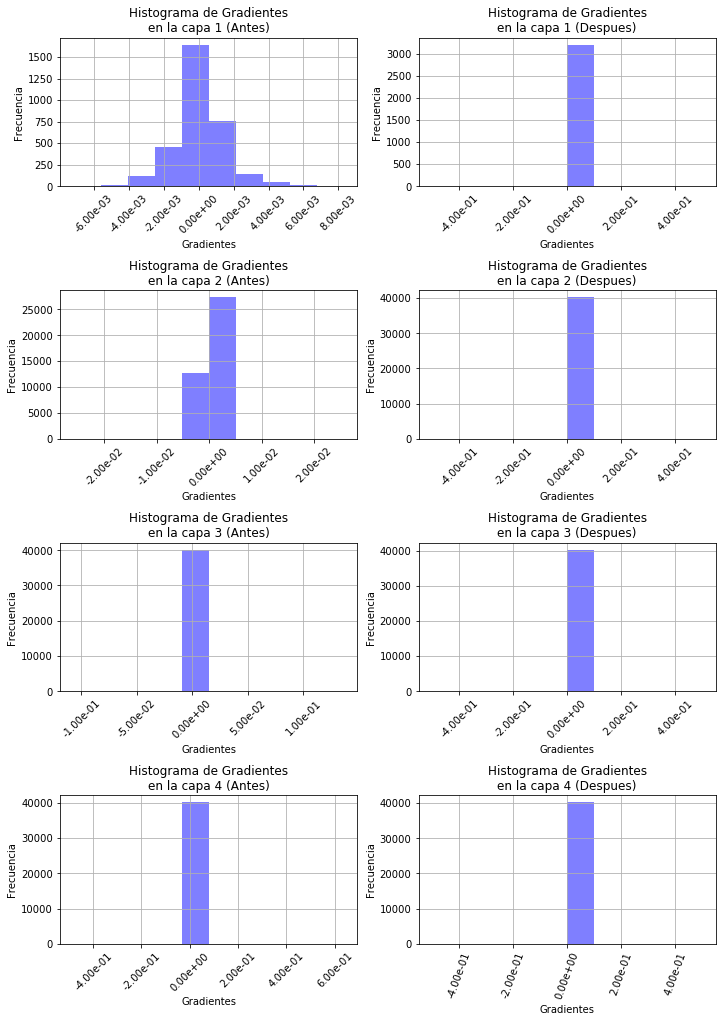

In [30]:
f, ax = plt.subplots(4,2,figsize=(10,14))
ax = ax.T.flatten()
for i in range(len(ax)):
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45)

index = 0
realIndex = 0
for index in range(len(itemE1_data)):
    
    if index%2 == 0:
        realIndex = int(index/2)
    else:
        realIndex = int(len(itemD_data)/2 + index//2)
        
    f.axes[index].hist(itemE1_data[realIndex], facecolor='blue', alpha=0.5)
    f.axes[index].set_xlabel('Gradientes')
    f.axes[index].set_ylabel('Frecuencia')
    number = (index//2)+1
    if index%2 == 0:
        tiempo = "Antes"
    else:
        tiempo = "Despues"
    f.axes[index].set_title('Histograma de Gradientes\nen la capa '+str(number)+' ('+tiempo+')')
    f.axes[index].grid(True)
    f.axes[index].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
    index+=1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 
plt.xticks(rotation=70)
plt.show()

In [31]:
model = Sequential()
model.add(Dense(200, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200,  kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(200, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [32]:
grad_bef_E2 = getGradients(model, X_train_scaled, y_train)

In [33]:
model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=1, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s 648us/step - loss: nan - val_loss: nan
Epoch 2/300
379/379 [==============================] - 0s 124us/step - loss: nan - val_loss: nan
Epoch 3/300
379/379 [==============================] - 0s 195us/step - loss: nan - val_loss: nan
Epoch 4/300
379/379 [==============================] - 0s 83us/step - loss: nan - val_loss: nan
Epoch 5/300
379/379 [==============================] - 0s 124us/step - loss: nan - val_loss: nan
Epoch 6/300
379/379 [==============================] - 0s 124us/step - loss: nan - val_loss: nan
Epoch 7/300
379/379 [==============================] - 0s 124us/step - loss: nan - val_loss: nan
Epoch 8/300
379/379 [==============================] - 0s 124us/step - loss: nan - val_loss: nan
Epoch 9/300
379/379 [==============================] - 0s 165us/step - loss: nan - val_loss: nan
Epoch 10/300
379/379 [==============================] - 0s 167us/step - loss: nan 

379/379 [==============================] - 0s 165us/step - loss: nan - val_loss: nan
Epoch 85/300
379/379 [==============================] - 0s 129us/step - loss: nan - val_loss: nan
Epoch 86/300
379/379 [==============================] - 0s 247us/step - loss: nan - val_loss: nan
Epoch 87/300
379/379 [==============================] - 0s 165us/step - loss: nan - val_loss: nan
Epoch 88/300
379/379 [==============================] - 0s 165us/step - loss: nan - val_loss: nan
Epoch 89/300
379/379 [==============================] - 0s 82us/step - loss: nan - val_loss: nan
Epoch 90/300
379/379 [==============================] - 0s 243us/step - loss: nan - val_loss: nan
Epoch 91/300
379/379 [==============================] - 0s 165us/step - loss: nan - val_loss: nan
Epoch 92/300
379/379 [==============================] - 0s 82us/step - loss: nan - val_loss: nan
Epoch 93/300
379/379 [==============================] - 0s 172us/step - loss: nan - val_loss: nan
Epoch 94/300
379/379 [=============

Epoch 167/300
379/379 [==============================] - 0s 124us/step - loss: nan - val_loss: nan
Epoch 168/300
379/379 [==============================] - 0s 123us/step - loss: nan - val_loss: nan
Epoch 169/300
379/379 [==============================] - 0s 143us/step - loss: nan - val_loss: nan
Epoch 170/300
379/379 [==============================] - 0s 105us/step - loss: nan - val_loss: nan
Epoch 171/300
379/379 [==============================] - 0s 124us/step - loss: nan - val_loss: nan
Epoch 172/300
379/379 [==============================] - 0s 177us/step - loss: nan - val_loss: nan
Epoch 173/300
379/379 [==============================] - 0s 100us/step - loss: nan - val_loss: nan
Epoch 174/300
379/379 [==============================] - 0s 116us/step - loss: nan - val_loss: nan
Epoch 175/300
379/379 [==============================] - 0s 124us/step - loss: nan - val_loss: nan
Epoch 176/300
379/379 [==============================] - 0s 165us/step - loss: nan - val_loss: nan
Epoch 177/

Epoch 250/300
379/379 [==============================] - 0s 133us/step - loss: nan - val_loss: nan
Epoch 251/300
379/379 [==============================] - 0s 165us/step - loss: nan - val_loss: nan
Epoch 252/300
379/379 [==============================] - 0s 82us/step - loss: nan - val_loss: nan
Epoch 253/300
379/379 [==============================] - 0s 82us/step - loss: nan - val_loss: nan
Epoch 254/300
379/379 [==============================] - 0s 206us/step - loss: nan - val_loss: nan
Epoch 255/300
379/379 [==============================] - 0s 186us/step - loss: nan - val_loss: nan
Epoch 256/300
379/379 [==============================] - 0s 165us/step - loss: nan - val_loss: nan
Epoch 257/300
379/379 [==============================] - 0s 165us/step - loss: nan - val_loss: nan
Epoch 258/300
379/379 [==============================] - 0s 143us/step - loss: nan - val_loss: nan
Epoch 259/300
379/379 [==============================] - 0s 165us/step - loss: nan - val_loss: nan
Epoch 260/30

In [34]:
grad_aft_E2 = getGradients(model, X_train_scaled, y_train)

In [35]:
itemE2_data = getDataFromGrad([1,2,3,4], grad_bef_E2, grad_aft_E2)

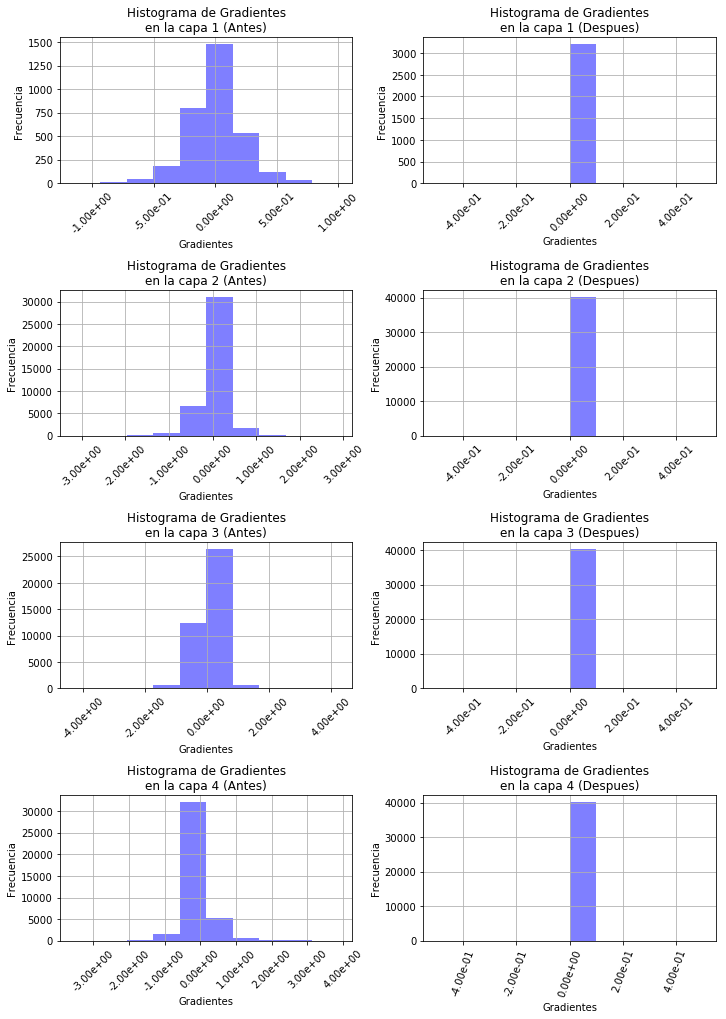

In [38]:
f, ax = plt.subplots(4,2,figsize=(10,14))
ax = ax.T.flatten()
for i in range(len(ax)):
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45)

index = 0
realIndex = 0
for index in range(len(itemE2_data)):
    
    if index%2 == 0:
        realIndex = int(index/2)
    else:
        realIndex = int(len(itemD_data)/2 + index//2)
        
    f.axes[index].hist(itemE2_data[realIndex], facecolor='blue', alpha=0.5)
    f.axes[index].set_xlabel('Gradientes')
    f.axes[index].set_ylabel('Frecuencia')
    number = (index//2)+1
    if index%2 == 0:
        tiempo = "Antes"
    else:
        tiempo = "Despues"
    f.axes[index].set_title('Histograma de Gradientes\nen la capa '+str(number)+' ('+tiempo+')')
    f.axes[index].grid(True)
    f.axes[index].xaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
    index+=1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 
plt.xticks(rotation=70)
plt.show()

> e) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.

> f) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?

In [39]:
model = Sequential()
model.add(Dense(1000, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
model.fit(np.asmatrix(X_train_scaled), 
                 np.asmatrix(y_train), 
                 epochs=300,
                 verbose=1, 
                 validation_data=(np.asmatrix(X_test_scaled), 
                                  np.asmatrix(y_test)
                                 )
                )

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s 619us/step - loss: 179779.4073 - val_loss: 663.5788
Epoch 2/300
379/379 [==============================] - 0s 165us/step - loss: 314.1351 - val_loss: 171.6224
Epoch 3/300
379/379 [==============================] - 0s 125us/step - loss: 125.5215 - val_loss: 108.1527
Epoch 4/300
379/379 [==============================] - 0s 67us/step - loss: 77.1995 - val_loss: 87.2470
Epoch 5/300
379/379 [==============================] - 0s 124us/step - loss: 56.4617 - val_loss: 70.5880
Epoch 6/300
379/379 [==============================] - 0s 124us/step - loss: 46.9508 - val_loss: 64.2583
Epoch 7/300
379/379 [==============================] - 0s 156us/step - loss: 40.2074 - val_loss: 56.4849
Epoch 8/300
379/379 [==============================] - 0s 98us/step - loss: 35.2386 - val_loss: 51.3244
Epoch 9/300
379/379 [==============================] - 0s 85us/step - loss: 30.8461 - val_loss: 50.6203
Epo

379/379 [==============================] - 0s 98us/step - loss: 1.6066 - val_loss: 16.8162
Epoch 79/300
379/379 [==============================] - 0s 124us/step - loss: 1.4995 - val_loss: 16.9962
Epoch 80/300
379/379 [==============================] - 0s 124us/step - loss: 1.5297 - val_loss: 16.8942
Epoch 81/300
379/379 [==============================] - 0s 82us/step - loss: 1.4713 - val_loss: 16.8108
Epoch 82/300
379/379 [==============================] - 0s 82us/step - loss: 1.4793 - val_loss: 16.6612
Epoch 83/300
379/379 [==============================] - 0s 165us/step - loss: 1.4805 - val_loss: 17.2192
Epoch 84/300
379/379 [==============================] - 0s 98us/step - loss: 1.4772 - val_loss: 17.4701
Epoch 85/300
379/379 [==============================] - 0s 90us/step - loss: 1.4637 - val_loss: 16.6635
Epoch 86/300
379/379 [==============================] - 0s 95us/step - loss: 1.3800 - val_loss: 16.7810
Epoch 87/300
379/379 [==============================] - 0s 82us/step - los

Epoch 156/300
379/379 [==============================] - 0s 82us/step - loss: 0.7824 - val_loss: 14.7158
Epoch 157/300
379/379 [==============================] - 0s 82us/step - loss: 0.7393 - val_loss: 14.5941
Epoch 158/300
379/379 [==============================] - 0s 133us/step - loss: 0.7604 - val_loss: 14.7611
Epoch 159/300
379/379 [==============================] - 0s 112us/step - loss: 0.7619 - val_loss: 14.8849
Epoch 160/300
379/379 [==============================] - 0s 82us/step - loss: 0.7571 - val_loss: 14.7218
Epoch 161/300
379/379 [==============================] - 0s 124us/step - loss: 0.7510 - val_loss: 14.6995
Epoch 162/300
379/379 [==============================] - 0s 124us/step - loss: 0.7435 - val_loss: 14.5839
Epoch 163/300
379/379 [==============================] - 0s 247us/step - loss: 0.7246 - val_loss: 14.7452
Epoch 164/300
379/379 [==============================] - 0s 82us/step - loss: 0.7321 - val_loss: 14.4761
Epoch 165/300
379/379 [===========================

379/379 [==============================] - 0s 165us/step - loss: 0.5039 - val_loss: 13.8155
Epoch 234/300
379/379 [==============================] - 0s 120us/step - loss: 0.5128 - val_loss: 13.7039
Epoch 235/300
379/379 [==============================] - 0s 106us/step - loss: 0.4952 - val_loss: 13.8769
Epoch 236/300
379/379 [==============================] - 0s 124us/step - loss: 0.4930 - val_loss: 13.7425
Epoch 237/300
379/379 [==============================] - 0s 82us/step - loss: 0.4895 - val_loss: 13.8195
Epoch 238/300
379/379 [==============================] - 0s 82us/step - loss: 0.4976 - val_loss: 13.9155
Epoch 239/300
379/379 [==============================] - 0s 102us/step - loss: 0.4801 - val_loss: 13.7058
Epoch 240/300
379/379 [==============================] - 0s 82us/step - loss: 0.4998 - val_loss: 13.7821
Epoch 241/300
379/379 [==============================] - 0s 82us/step - loss: 0.4697 - val_loss: 13.6620
Epoch 242/300
379/379 [==============================] - 0s 165u